In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import math,random, re
from bs4 import BeautifulSoup

pd.set_option('display.max_colwidth',1000)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 2.3MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.2-cp36-none-any.whl size=29938 sha256=268bd8a7bc82bba51355c8c9cf5704ced3a91c94615fbac8f45c200b01e3ed6c
  Stored in directory: /tmp/.cache/pip/wheels/d8/e1/95/7fa0b466d35f4280a8842a6653f9cd37f89e83832770daf85f
  Created wheel for py-params: filename=py_params-0.8.2-cp36-none-any.whl size=4633 sha256=143e4ecc685d73125bdf4fc9cc88801c457827d1e1085281ff358cfe1aef2b8e
  Stored in directory: /tmp/.cache/pip/wheels/83/3a/9c/baf35d6f17f0c2c6b61bf8ac3ab9fc12df0e41432ccaeecacb
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16196 sha256=2e83426b1cc8a600d18b806d6d3dad6e43df9ddeca65bd86498db86f0f3f0526
  Stored in directory: /tmp/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow


In [3]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

In [4]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1", trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [5]:
train_cols = ["id", "keyword", "location", "text", "target"]
train = pd.read_csv(
    "/kaggle/input/nlp-getting-started/train.csv",
    header=None,
    names=train_cols,
    skiprows=1,
    engine="python",
    encoding="latin1"
)

test_cols = ["id", "keyword", "location", "text"]
test = pd.read_csv(
    "/kaggle/input/nlp-getting-started/test.csv",
    header=None,
    names=test_cols,
    skiprows=1,
    engine="python",
    encoding="latin1"
)

def fix_keyword(x):
  return str(x[1]).replace('%20', ' ')

def new_text(x):
  return str(x[1]) + ' ' + str(x[2]) + ' ' +str(x[3])


def clean_tweet(tweet):
    #tweet = BeautifulSoup(tweet, "lxml").get_text()
    # Removing the URL links
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    # Removing the @
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    # Keeping only letters
    tweet = re.sub(r"[^a-zA-Z0-9!?']", ' ', tweet)
    # Removing additional whitespaces
    tweet = re.sub(r" +", ' ', tweet)
    tweet = re.sub(r"\?+", ' Q', tweet)
    tweet = re.sub(r"\!+", ' X', tweet)
    return tweet

def encode_sentence(sent):
    return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]


train.keyword = train.apply(fix_keyword, axis=1)  
train['new_text'] = train.apply(new_text, axis=1)
train_clean = [clean_tweet(tweet) for tweet in train.new_text]
train_inputs = [encode_sentence(sentence) for sentence in train_clean]
train_labels = train.target.values

test.keyword = test.apply(fix_keyword, axis=1)  
test['new_text'] = test.apply(new_text, axis=1)
test_clean = [clean_tweet(tweet) for tweet in test.new_text]
test_inputs = [encode_sentence(sentence) for sentence in test_clean]

In [6]:
def get_ids(tokens):
    return tokenizer.convert_tokens_to_ids(tokens)

def get_mask(tokens):
    return np.char.not_equal(tokens, "[PAD]").astype(int)

def get_segments(tokens):
    seg_ids = []
    current_seg_id = 0
    for tok in tokens:
        seg_ids.append(current_seg_id)
        if tok == "[SEP]":
            current_seg_id = 1-current_seg_id # turns 1 into 0 and vice versa
    return seg_ids

In [7]:
data_with_len = [[sent, train_labels[i], len(sent)]
                 for i, sent in enumerate(train_inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
train_all = [
    (
        [
            get_ids(sent_lab[0]),
            get_mask(sent_lab[0]),
            get_segments(sent_lab[0])
        ],
             sent_lab[1]
    )
    for sent_lab in data_with_len]
    #for sent_lab in data_with_len if sent_lab[2] > 7]

In [8]:
# A list is a type of iterator so it can be used as generator for a dataset
all_dataset = tf.data.Dataset.from_generator(lambda: train_all, output_types=(tf.int32, tf.int32))

In [9]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE,
                                       padded_shapes=((3, None), ()),
                                       padding_values=(0, 0))

NB_BATCHES = math.ceil(len(train_all) / BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES // 10
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

In [10]:
class DCNNBERTEmbedding(tf.keras.Model):
    
    def __init__(self,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 name="dcnn"):
        super(DCNNBERTEmbedding, self).__init__(name=name)
        
        #self.bert_layer = hub.KerasLayer(
        #    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
        #    trainable=True)

        self.bert_layer = hub.KerasLayer(
            "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1",
            trainable=True)

        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def embed_with_bert(self, all_tokens):
        _, embs = self.bert_layer([all_tokens[:, 0, :],
                                   all_tokens[:, 1, :],
                                   all_tokens[:, 2, :]])
        return embs

    def call(self, inputs, training):
        x = self.embed_with_bert(inputs)

        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [11]:
NB_FILTERS = 128
FFN_UNITS = 256
NB_CLASSES = 2

DROPOUT_RATE = 0.2

BATCH_SIZE = 32
NB_EPOCHS = 3

In [12]:
Dcnn = DCNNBERTEmbedding(nb_filters=NB_FILTERS,
                         FFN_units=FFN_UNITS,
                         nb_classes=NB_CLASSES,
                         dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 #optimizer="adam",
                 optimizer=tf.optimizers.Adam(learning_rate=2e-5),
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

Dcnn.fit(all_batched, epochs=NB_EPOCHS)

Epoch 1/3
238/238 [==============================] - 115s 481ms/step - loss: 0.4463 - accuracy: 0.8027
Epoch 2/3
238/238 [==============================] - 71s 299ms/step - loss: 0.3249 - accuracy: 0.8675
Epoch 3/3
238/238 [==============================] - 71s 300ms/step - loss: 0.2059 - accuracy: 0.9220


In [13]:
results = Dcnn.evaluate(test_dataset)
print(results)

     23/Unknown - 6s 262ms/step - loss: 0.1660 - accuracy: 0.9402[0.16597764323587003, 0.9402174]


In [14]:
cols = ["id", "keyword", "location", "text"]
test = pd.read_csv(
    "/kaggle/input/nlp-getting-started/test.csv",
    header=None,
    names=cols,
    skiprows=1,
    engine="python",
    encoding="latin1"
)

test.keyword = test.apply(fix_keyword, axis=1)  
test['new_text'] = test.apply(new_text, axis=1)  

test_clean = [clean_tweet(tweet) for tweet in test.new_text]
test_inputs = [encode_sentence(sentence) for sentence in test_clean]

In [15]:
preds = []

for sentence in test_inputs:
    input = [[
            get_ids(sentence),
            get_mask(sentence),
            get_segments(sentence)
        ]]
    preds.append(int(np.round(Dcnn.predict(input)[0][0])))
    
    if len(preds) % 100 == 0:
        print('Predictions made:', len(preds))


Predictions made: 100
Predictions made: 200
Predictions made: 300
Predictions made: 400
Predictions made: 500
Predictions made: 600
Predictions made: 700
Predictions made: 800
Predictions made: 900
Predictions made: 1000
Predictions made: 1100
Predictions made: 1200
Predictions made: 1300
Predictions made: 1400
Predictions made: 1500
Predictions made: 1600
Predictions made: 1700
Predictions made: 1800
Predictions made: 1900
Predictions made: 2000
Predictions made: 2100
Predictions made: 2200
Predictions made: 2300
Predictions made: 2400
Predictions made: 2500
Predictions made: 2600
Predictions made: 2700
Predictions made: 2800
Predictions made: 2900
Predictions made: 3000
Predictions made: 3100
Predictions made: 3200


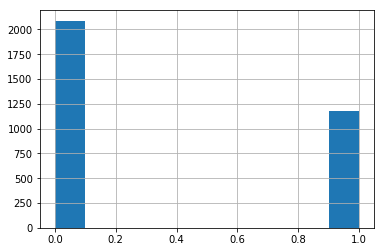

In [16]:
test['target'] = preds

submission = test[['id', 'target']]
submission.to_csv('submission.csv', index=False)

submission.target.hist()

In [17]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
